<a href="https://colab.research.google.com/github/DRodriguez615/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/UFC_PREDICTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install eli5

In [0]:
from google.colab import files
uploaded=files.upload()
uploaded

In [0]:
!unzip ufcdata.zip

In [0]:
df = pd.read_csv('data.csv') # will use the columns date, and r_fighter, b_fighter
df1 = pd.read_csv('preprocessed_data.csv') #will use this set and a couple columns from the set above
df2 = pd.read_csv('raw_fighter_details.csv') #wont use
df3 = pd.read_csv('raw_total_fight_data.csv') #wont use

In [0]:
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [7]:
# will most likely only use r/b_fighter and date columns from this set
print(df.shape)
df.head()

(5144, 145)


R_fighter       B_fighter  ... B_age R_age
0          Henry Cejudo   Marlon Moraes  ...  31.0  32.0
1  Valentina Shevchenko     Jessica Eye  ...  32.0  31.0
2         Tony Ferguson  Donald Cerrone  ...  36.0  35.0
3         Jimmie Rivera        Petr Yan  ...  26.0  29.0
4           Tai Tuivasa   Blagoy Ivanov  ...  32.0  26.0

[5 rows x 145 columns]

In [0]:
pd.set_option('display.max_rows', 146)
df.dtypes

In [0]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
# check the dates
# train from 1993-2013
# test from 2014-2019
df['date'].

0      2019-06-08
1      2019-06-08
2      2019-06-08
3      2019-06-08
4      2019-06-08
          ...    
5139   1993-11-12
5140   1993-11-12
5141   1993-11-12
5142   1993-11-12
5143   1993-11-12
Name: date, Length: 5144, dtype: datetime64[ns]

In [11]:
#will use this set
# need to add fighter names and date columns
print(df1.shape)
df1.head()

(3592, 160)


Winner  title_bout  ...  R_Stance_Southpaw  R_Stance_Switch
0    Red        True  ...                  0                0
1    Red        True  ...                  1                0
2    Red       False  ...                  0                0
3   Blue       False  ...                  0                0
4   Blue       False  ...                  1                0

[5 rows x 160 columns]

In [12]:
# questions from assignemt 1

# Winner column will be the target
# Classification problem
# 2 classes: red and blue
# classes imbalanced? 
# majority class frequency (red) falls between >=50% and <70% range
# evaluation metric = accuracy
# will do a time-based split
y = df1['Winner']
y.value_counts(normalize=True)

Red     0.662584
Blue    0.337416
Name: Winner, dtype: float64

In [13]:
# adding these 3 columns to dataset df1
df1['date'] = df['date']
df1['Red_fighter'] = df['R_fighter']
df1['Blue_fighter'] = df['B_fighter']
print(df1.shape)
df1.head()

(3592, 163)


Winner  title_bout  ...           Red_fighter    Blue_fighter
0    Red        True  ...          Henry Cejudo   Marlon Moraes
1    Red        True  ...  Valentina Shevchenko     Jessica Eye
2    Red       False  ...         Tony Ferguson  Donald Cerrone
3   Blue       False  ...         Jimmie Rivera        Petr Yan
4   Blue       False  ...           Tai Tuivasa   Blagoy Ivanov

[5 rows x 163 columns]

In [14]:
df1.isnull().sum().sum()

0

In [129]:
# train from 1993-2015
# test from 2016-2019

train = df1[df1['date'].dt.year <= 2017]
test = df1[df1['date'].dt.year >= 2018]


train.shape, test.shape

((2895, 163), (697, 163))

In [0]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [16]:
from sklearn.model_selection import train_test_split
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Winner'], random_state=42)
train.shape, val.shape, test.shape

((1560, 163), (391, 163), (1641, 163))

In [17]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

target = 'Winner'
features = train.columns.drop([target, 'date', 'R_Height_cms', 'B_Height_cms' ])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7468030690537084


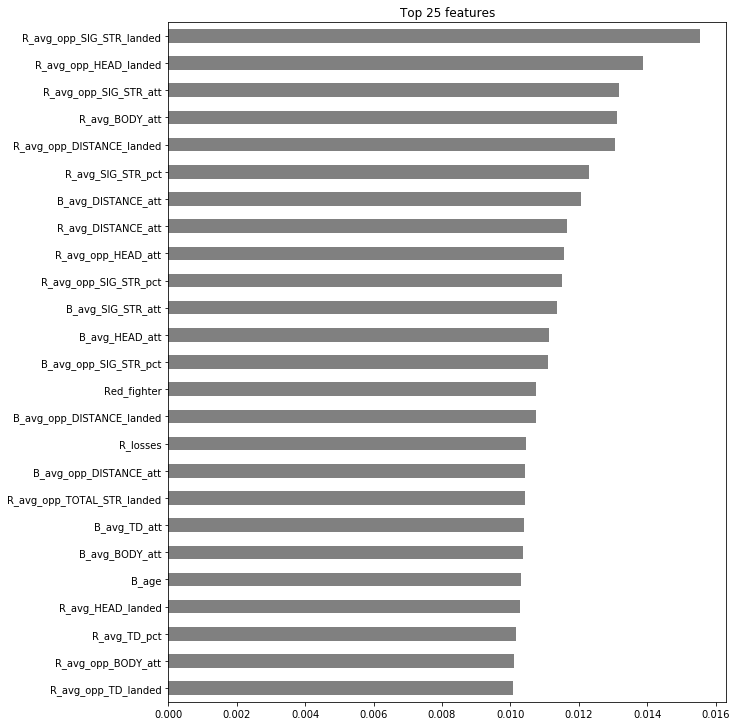

In [24]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

n = 25
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [27]:
# drop column performance
column  = 'R_avg_opp_TD_landed'


# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without R_avg_opp_TD_landed: 0.7468030690537084
Validation Accuracy with R_avg_opp_TD_landed: 0.7468030690537084
Drop-Column Importance for R_avg_opp_TD_landed: 0.0


In [32]:
# trying more features
# before sequence of the feature to be permuted
feature = 'Blue_fighter'
X_val[feature].head()

2037            Holly Holm
2427    Richardson Moreira
1929         Mirsad Bektic
2901       Gabriel Gonzaga
1898         Eddie Alvarez
Name: Blue_fighter, dtype: object

In [0]:
# permute
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [47]:
# after sequence has changed
X_val_permuted[feature].head()

2037       Nikita Krylov
2427    Alistair Overeem
1929        Issei Tamura
2901         Ryan Jensen
1898            Ben Wall
Name: Blue_fighter, dtype: object

In [48]:
# Getting the permutation importance

score_permuted = pipeline.score(X_val_permuted, y_val) #Calc. accuracy on the permuted val dataset

print(f'Validation accuracy with {feature}: {score_with}')
print(f'Validation accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation importance: {score_with - score_permuted}')

Validation accuracy with Blue_fighter: 0.7468030690537084
Validation accuracy with Blue_fighter permuted: 0.7468030690537084
Permutation importance: 0.0


In [62]:
# trying a different feature
feature = 'R_Reach_cms'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

score_permuted = pipeline.score(X_val_permuted, y_val) #Calc. accuracy on the permuted val dataset

print(f'Validation accuracy with {feature}: {score_with}')
print(f'Validation accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation importance: {score_with - score_permuted}')

Validation accuracy with R_Reach_cms: 0.7468030690537084
Validation accuracy with R_Reach_cms permuted: 0.7468030690537084
Permutation importance: 0.0


In [63]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

In [67]:
# calculating permutation importances
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [72]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

B_avg_opp_DISTANCE_landed    0.007673
R_avg_TOTAL_STR_att          0.005627
R_avg_HEAD_landed            0.004604
R_avg_LEG_att                0.004604
R_avg_opp_PASS               0.004604
                               ...   
B_avg_opp_SIG_STR_pct       -0.003581
Red_fighter                 -0.003581
R_avg_opp_TD_att            -0.004604
R_avg_opp_SIG_STR_pct       -0.005115
B_avg_CLINCH_landed         -0.006650
Length: 159, dtype: float64

In [70]:
# displaying permutation importances
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

In [73]:
print('Shape before removing features: ', X_train.shape)

Shape before removing features:  (1560, 159)


In [0]:
minimum_importance = 0

mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [75]:
# accuracy stayed the same
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.7468030690537084


In [82]:
# xgboost
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
# fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
      

In [83]:
from sklearn.metrics import accuracy_score
# accuracy score went up
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7519181585677749


In [124]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    scale_pos_weight=0.1,
    n_estimators=1000,
    max_depth = 3,
    learning_rate = 0.5,
    n_jobs=-1,
)
eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds=100,
          )

[0]	validation_0-error:0.623718	validation_1-error:0.598466
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.621154	validation_1-error:0.578005
[2]	validation_0-error:0.611538	validation_1-error:0.578005
[3]	validation_0-error:0.589103	validation_1-error:0.57289
[4]	validation_0-error:0.576282	validation_1-error:0.570332
[5]	validation_0-error:0.553205	validation_1-error:0.549872
[6]	validation_0-error:0.537821	validation_1-error:0.542199
[7]	validation_0-error:0.526923	validation_1-error:0.526854
[8]	validation_0-error:0.510256	validation_1-error:0.521739
[9]	validation_0-error:0.491026	validation_1-error:0.519182
[10]	validation_0-error:0.479487	validation_1-error:0.508951
[11]	validation_0-error:0.475	validation_1-error:0.503836
[12]	validation_0-error:0.457051	validation_1-error:0.496164
[13]	validation_0-error:0.442308	validation_1-error:0.49104

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1, seed=None,
              silent=None, subsample=1, verbosity=1)

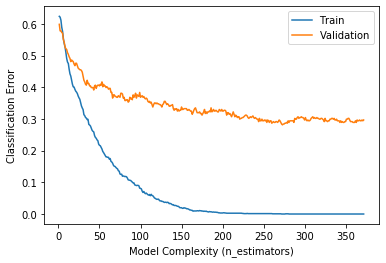

In [127]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
# plt.ylim((0.10, 0.35))
plt.legend();